# L11.1 kNN Practice
---
이름: 김태산

학과: 자동차공학과

학번: 20143211

---

### 과제 목표: kNN 분류기를 구현하고 kNN 분류기가 분류한 결과의 정확도를 측정하여 Iris 데이터셋에 대해 최적의 k 값을 찾아본다.

### 모듈 불러오기
- 사용할 모듈 import 하기

In [59]:
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from collections import Counter

### Iris dataset
- 아이리스(붓꽃) 데이터
 - 붓꽃 종류별로 꽃받침과 꽃잎의 길이 및 너비를 측정한 데이터셋이다.
 - 데이터셋의 각 샘플은 꽃받침과 꽃잎의 길이 및 너비의 4차원 특징 벡터와 해당 샘플의 레이블이 ','로 구분되어 있다.

### 데이터 불러오기
- Iris 클래스를 생성하여 Iris 데이터셋의 특징 벡터와 레이블을 저장한다.

In [49]:
class Iris:
  def __init__(self, fvector, label):
    self.fvector = fvector
    self.label = label

dataset = []

with open("/content/drive/MyDrive/datasets/IrisDataset/iris.data", 'r') as f:
  for line in f:
    item = line.strip().split(',')                      # 데이터의 양쪽 공백을 제거하고 ','를 기준으로 분할한다.
    fvector = [float(feature) for feature in item[:-1]] # 데이터셋의 특징값들이 string 형태로 저장되어 있으므로 이를 실수형으로 변환하여 특징 벡터로 만든다.
    label = item[-1]                                    # 데이터셋의 레이블을 입력한다.
    dataset.append(Iris(fvector, label))

print(dataset[-1].fvector)
del dataset[-1]            # Iris 데이터셋 파일의 가장 마지막 줄이 공백으로 되어있어 의미 없는 값을 가지기 때문에 dataset의 마지막 element를 지워준다.
print(dataset[-1].fvector) # 공백으로 된 샘플을 삭제하여 dataset의 마지막 샘플이 의미 있는 샘플이 된 것을 확인할 수 있다.

[]
[5.9, 3.0, 5.1, 1.8]


### 데이터 살펴보기
- 사용하고 있는 Iris 데이터셋은 4차원의 특징을 가지기 때문에 이를 한번에 시각화하기는 어렵다.
- 따라서 아래와 같이 4차원의 특징 중 2가지의 특징만으로 데이터를 시각화하는 방식을 통해 데이터를 살펴볼 수 있다.

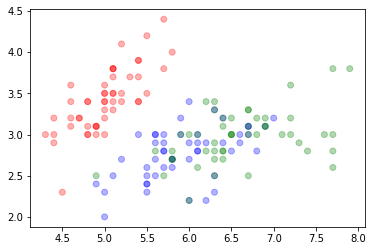

In [50]:
X = [sample.fvector[0] for sample in dataset]
Y = [sample.fvector[1] for sample in dataset]

# 붓꽃의 종에 따라 색을 달리하여 시각화하기 위한 코드이다.
species = {"Iris-setosa":'red', "Iris-versicolor":'blue', "Iris-virginica": 'green'}
color = [species[sample.label] for sample in dataset]

plt.scatter(X, Y, c=color, alpha=0.3) # 각 샘플의 색을 지정할 때에는 c에 샘플 갯수만큼 색을 입력하면 된다.
                                      # alpha는 색상의 투명도를 지정하는 파라미터로, 0이면 완전 투명, 1이면 완전 불투명이다.
plt.show()

- 다음과 같이 샘플에서 가져올 특징값을 변경하면서 서로 다른 특징값을 시각화하여 비교해볼 수 있다.

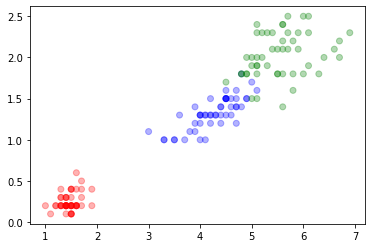

In [51]:
X = [sample.fvector[2] for sample in dataset]
Y = [sample.fvector[3] for sample in dataset]
plt.scatter(X, Y, c=color, alpha=0.3) 
plt.show()

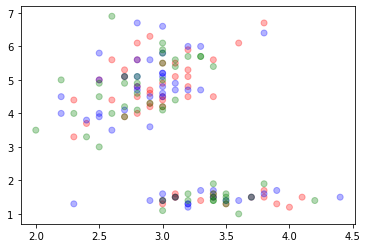

In [93]:
X = [sample.fvector[1] for sample in dataset]
Y = [sample.fvector[2] for sample in dataset]
plt.scatter(X, Y, c=color, alpha=0.3) 
plt.show()

### 데이터 분리하기
- train data와 test data로 분리
 - 붓꽃 데이터셋은 붓꽃의 종을 기준으로 정렬되어 있으므로 train data와 test data로 분리하기 전에 이를 random.shuffle을 사용하여 무작위로 섞어주어야 한다.
 - 이번 과제에서는 전체 데이터셋의 80%를 train data로 사용한다.

In [53]:
random.shuffle(dataset)
train_size = int(len(dataset) * 0.8)

train = dataset[:train_size]
test = dataset[train_size:]

### distance()
- kNN을 구하기 위해 두 벡터의 거리를 구하는 함수를 구현한다.
- 이번 과제에서는 Euclidean distance를 사용하여 거리를 측정한다.

In [58]:
def distance(v1, v2):
  return sum((x - y) ** 2 for x, y in zip(v1, v2)) ** 0.5

### knn_classify()
- 특정 샘플에서의 k개의 kNN을 찾고 이를 통해 특정 샘플의 붓꽃 label을 분류하는 함수를 구현한다.
- 위에서 구현한 distance 함수를 사용하여 특정 샘플과 모든 train data의 거리를 계산하고 정렬하여 거리가 가장 가까운 k개의 샘플을 뽑으면 kNN을 구할 수 있다.
- kNN에서 가장 많이 나온 label을 특정 샘플의 label로 예측하게 된다.

In [73]:
def kNNClassifier(k, query, train):
  knns = sorted((distance(query, sample.fvector), sample.label) for sample in train)[:k]
  predicted = Counter((knn[1] for knn in knns)).most_common(1)[0][0] # Counter의 most_common 메서드를 사용하면 가장 많이 등장한 순의 리스트가 리턴되고,
                                                                     # 리스트의 각 element는 가장 많이 등장한 값과 등장 횟수가 입력되므로,
                                                                     # 인덱싱을 통해 가장 많이 등장한 label만 입력되도록 한다.
  return predicted

- 테스트 결과를 보면, 예측한 label이 테스트 샘플의 label과 일치하는 것을 확인할 수 있다.

In [74]:
label = kNNClassifier(3, test[0].fvector, train)
print("Test sample label:", test[0].label)
print("Predicted label:", label)

Test sample label: Iris-versicolor
Predicted label: Iris-versicolor


In [75]:
label = kNNClassifier(3, test[1].fvector, train)
print("Test sample label:", test[1].label)
print("Predicted label:", label)

Test sample label: Iris-virginica
Predicted label: Iris-virginica


### test 해보기
- 모든 test data에 대해 kNNClassifier로 label을 예측해보고, test data의 실제 label과 비교하여 정확도를 계산해본다.
- 실제 label과 예측한 label이 같은 샘플의 갯수를 전체 test 샘플의 갯수로 나누어 정확도를 계산한다.
- 결과를 보면, 정확도가 90% 이상이 되는 것을 확인할 수 있다.

In [79]:
k = 3
correct = sum(1 for sample in test if kNNClassifier(k, sample.fvector, train) == sample.label)
accuracy = correct / len(test)
print("Accuracy:", accuracy)

Accuracy: 0.9333333333333333


### 최적의 k 찾기
- label을 분류하는데 최적의 k 값을 찾기 위해 k = 1부터 시작하여 1씩 증가시켜가며 label을 구하고 정확도를 계산한다.
- 정확도가 가장 높을 때의 k가 최적의 k 값이 된다.
- k는 1부터 20까지 변화시켜가며 정확도를 계산하였다.
- 또한 신뢰도를 높이기 위해 각각의 k 마다 총 num_trials = 100회씩 반복하여 정확하게 예측한 label의 갯수를 세었다.
- 아래의 그래프는 k에 대한 accuracy를 시각화한 것이다.
- 모든 k에 대한 정확도가 0.96 이상이므로 어떤 k를 사용하더라도 매우 좋은 성능을 보이는 것을 알 수 있다.
- 또한 k=13일 때 가장 높은 정확도를 보이고, k=13을 기준으로 대략적으로 볼록한 모양의 그래프를 그리는 것을 알 수 있다.
- 이번 과제에서 사용한 Iris 데이터셋은 크기가 작은 데이터셋으로, 이보다 크기가 큰 데이터셋을 사용하면 좀 더 정확한 결과를 얻을 수 있을 것이다.
- 또한 반복 횟수(num_trials)를 높이면 더 신뢰도가 높은 결과를 얻을 수 있을 것이다.

100%|██████████| 100/100 [00:14<00:00,  6.67it/s]



k: 1, acurracy: 0.96
k: 2, acurracy: 0.96
k: 3, acurracy: 0.9626666666666667
k: 4, acurracy: 0.9616666666666667
k: 5, acurracy: 0.966
k: 6, acurracy: 0.964
k: 7, acurracy: 0.9686666666666667
k: 8, acurracy: 0.9686666666666667
k: 9, acurracy: 0.968
k: 10, acurracy: 0.968
k: 11, acurracy: 0.9683333333333334
k: 12, acurracy: 0.968
k: 13, acurracy: 0.97
k: 14, acurracy: 0.9683333333333334
k: 15, acurracy: 0.967
k: 16, acurracy: 0.9673333333333334
k: 17, acurracy: 0.9656666666666667
k: 18, acurracy: 0.9646666666666667
k: 19, acurracy: 0.9626666666666667
k: 20, acurracy: 0.9603333333333334


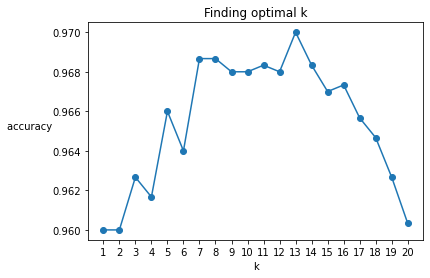

In [95]:
num_trials = 100
train_size = int(len(dataset) * 0.8)
correct = [0] * 20

for _ in tqdm(range(num_trials)):
  random.shuffle(dataset)
  train = dataset[:train_size]
  test = dataset[train_size:]

  for k in range(1, 21):
    correct[k-1] += sum(1 for sample in test if kNNClassifier(k, sample.fvector, train) == sample.label)

accuracies = [c / (len(test) * num_trials) for c in correct]

print()
for i in range(len(accuracies)):
  print(f"k: {i + 1}, acurracy: {accuracies[i]}")

plt.plot(range(1, 21), accuracies, 'o-')
plt.title("Finding optimal k")
plt.xlabel("k")
plt.ylabel("accuracy            ", rotation=0)
plt.xticks(range(1, 21))
plt.show()